# Mean Force Integration

Import HILLS and COLVAR files, compute the mean force and integrate using the pyMFI (would be) module. 

### 2D - Periodic CV space example - Alanine Dipeptide. 

The path to this notebook is: /Users/matteo/Projects/MFI
folder "AlanineDipeptide_pyMFI" already exists
Total no. of Gaussians analysed: 1000
|10/1000|==> Average Mean Force Error: 57.265260056996716
|20/1000|==> Average Mean Force Error: 61.102039876137546
|30/1000|==> Average Mean Force Error: 65.17246981713694
|40/1000|==> Average Mean Force Error: 71.77924018113721
|50/1000|==> Average Mean Force Error: 67.06110891029202
|60/1000|==> Average Mean Force Error: 66.94486366230181
|70/1000|==> Average Mean Force Error: 63.60116376236704
|80/1000|==> Average Mean Force Error: 65.61959519654198
|90/1000|==> Average Mean Force Error: 67.12653122861354
|100/1000|==> Average Mean Force Error: 62.36999948225979
|110/1000|==> Average Mean Force Error: 66.39816891606336
|120/1000|==> Average Mean Force Error: 69.80733157269782
|130/1000|==> Average Mean Force Error: 65.14693831185818
|140/1000|==> Average Mean Force Error: 57.52778409820004
|150/1000|==> Average Mean Force Error: 56.3452527265

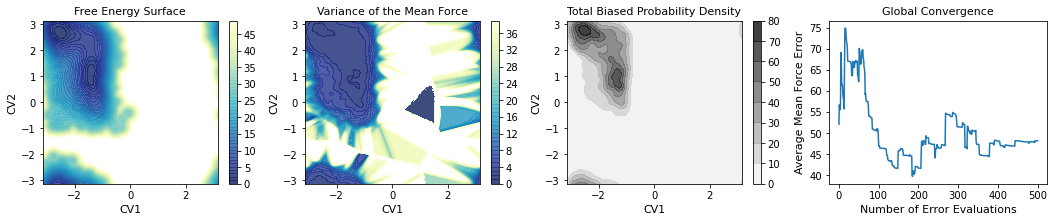

In [1]:
import numpy as np
from pyMFI import MFI

path = os.getcwd()
print("The path to this notebook is:", path)

os.chdir(path)
try: os.mkdir("AlanineDipeptide_pyMFI")
except: print("folder \"AlanineDipeptide_pyMFI\" already exists")
os.chdir("AlanineDipeptide_pyMFI")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS40")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position40")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history,Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, log_pace = 100, error_pace = 500, WellTempered=1, nhills=1000, periodic=1)

#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe_map, ofe_history)

os.chdir(path)



### 2D - Non-periodic case | Bjola potential

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin

path = os.getcwd()
os.chdir(path)
try: os.mkdir("Antoniu_2D_potential")
except: print("folder \"Antoniu_2D_potential\" already exists")
os.chdir("Antoniu_2D_potential")


#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_potential")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_potential")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 50, error_pace = 500, nhills=5000)

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

#Simpler integration test
[X, Y, FES2] = MFI.intg_2D(Ftot_x, Ftot_y) 

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe_map, ofe_history, FES_lim=20, ofe_map_lim=16)

folder "Antoniu_2D_potential" already exists


UnboundLocalError: local variable 'hills' referenced before assignment

### 2D patching independent,  short simulations | Bjola potential

folder "Antoniu_2D_potential" already exists
Simulation: 0
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 9.8560911807163
Simulation: 1
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 5.4408674522825216
Simulation: 2
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 7.092944217130059
Simulation: 3
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 7.738288164024022
Simulation: 4
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 10.386335547948628
Simulation: 5
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 7.121468450187911
Simulation: 6


KeyboardInterrupt: 

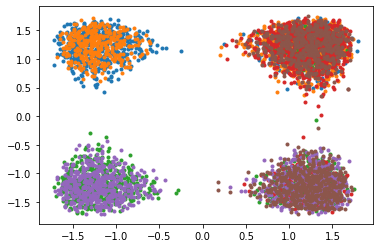

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin


os.chdir("/Users/matteo/Projects/MFI")
try: os.mkdir("Antoniu_2D_potential")
except: print("folder \"Antoniu_2D_potential\" already exists")
os.chdir("Antoniu_2D_potential")


nhills = 500
master = []
all_hills= []
error_history = []
ipos=1.3*(2 * np.random.rand(2) - 1)

for simulation in np.arange(0,50): 
    #RUN short sim from random location
    langevin.run_2D(ipos=ipos,tag=simulation)
    !plumed pesmd < input  >/dev/null
    
    #Read the HILLS file
    
    print('Simulation: '+str(simulation))
    HILLS=MFI.load_HILLS_2D(hills_name="HILLS_"+str(simulation))
    plt.plot(HILLS[:,1],HILLS[:,2],'.')
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name="position_"+str(simulation))
    
    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 1, error_pace = 1, nhills=nhills)
    #Prepare input for patching & error calculation
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y])
    [FX,FY,FD,error] = MFI.patch_2D_error(master)
    
    error_history.append(sum(sum(error)) / (np.shape(error)[0]*np.shape(error)[1]))


    #ipos=1.3*(2 * np.random.rand(2) - 1)    

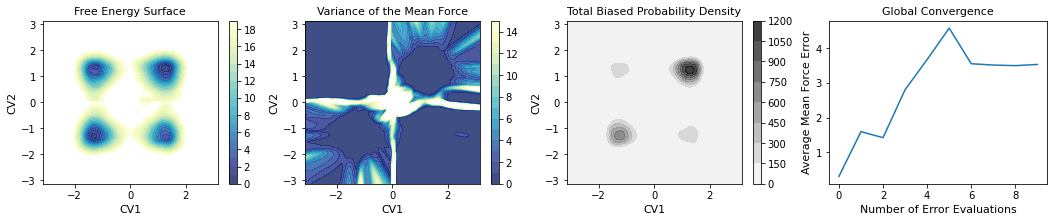

In [7]:
#integration on a periodic domain
[X, Y, FES] = MFI.intg_2D(FX, FY,nbins=(200,200))

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, FD,error,error_history,FES_lim=20, ofe_map_lim=16)


folder "Invernizzi_2D_potential" already exists
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 15.240244408135652
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 12.139370261819195
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 10.467107995809135
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 12.09990307860079
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 12.935361970315034
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 13.26027791855139
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 13.220536344789497
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 14.369280716170923
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 10.934912568839525
Total no. of Gaussians analysed: 500
|500/500|==> Average Mean Force Error: 10.158559346329419
Tota

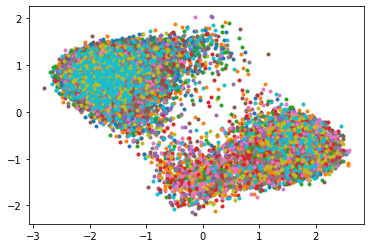

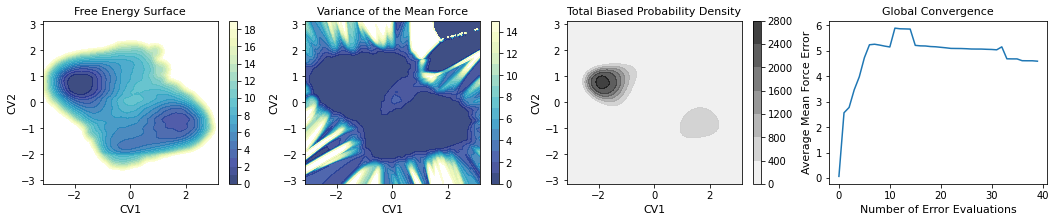

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pyMFI import MFI
from pyMFI import langevin

os.chdir("/Users/matteo/Projects/MFI")
try: os.mkdir("Invernizzi_2D_potential")
except: print("folder \"Invernizzi_2D_potential\" already exists")
os.chdir("Invernizzi_2D_potential")

master = []
all_hills= []
ipos=1.3*(2 * np.random.rand(2) - 1)
nhills=-1
error_history = []

for simulation in np.arange(0,40): 
    #RUN short sim from random location
    #langevin.run_2D_Invernizzi(ipos=ipos,tag=simulation)
    #!plumed pesmd < input  >/dev/null

    print('Simulation: '+str(simulation))

    #Read the HILLS file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_"+str(simulation))
    plt.plot(HILLS[:,1],HILLS[:,2],'.')
    #Read the Colvar File
    [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_"+str(simulation))

    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe_map, ofe_history, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 1, error_pace = 1, nhills=nhills)
    #Prepare input for patching & error calculation
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y])
    [FX,FY,FD,error] = MFI.patch_2D_error(master)
    error_history.append(sum(sum(error)) / (np.shape(error)[0]*np.shape(error)[1]))
    ipos=1.3*(2 * np.random.rand(2) - 1)

#integration on a periodic domain
[X, Y, FES] = MFI.intg_2D(FX, FY)

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, FD,error,error_history,FES_lim=20, ofe_map_lim=16)
    